In [ ]:
#pip install glmtools

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

import sys
sys.path.append('code')
from se_utils import extract_se
from tfr_utils import compute_tfr
from utils import apply_specparam, compute_flattened_spectra
from allen_utils import get_lfp_epochs

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# Example cache directory path, it determines where downloaded data will be stored
output_dir = '/root/capsule/scratch/allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/'
import os
manifest_path = os.path.join(output_dir, 'manifest.json')
DOWNLOAD_COMPLETE_DATASET = True

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
from glmtools.fit import ols_fit

from settings import FREQS,SESSIONS

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


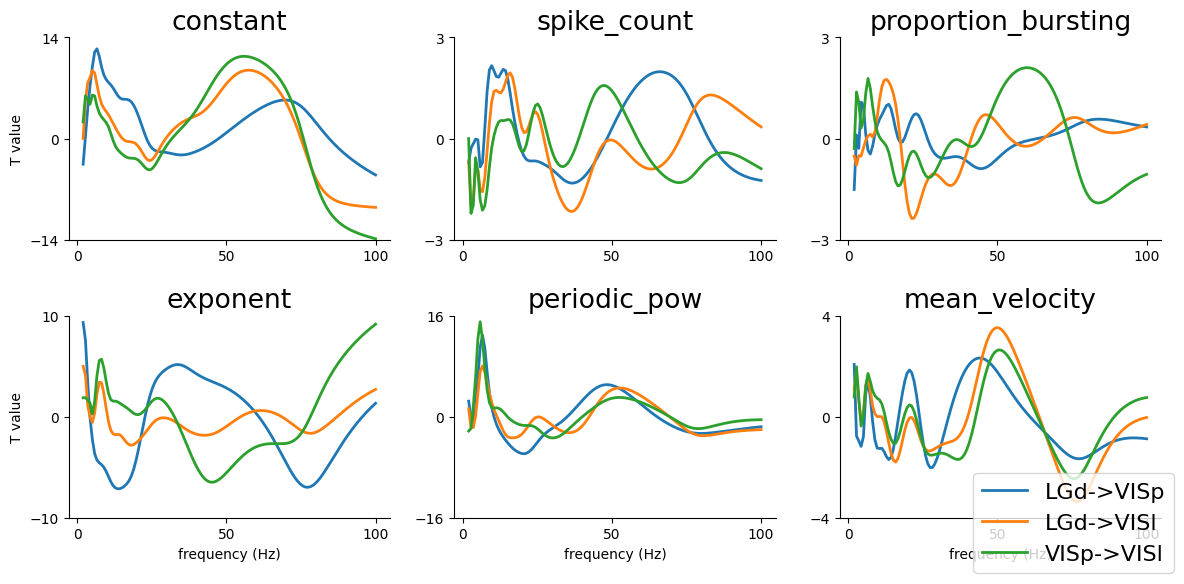

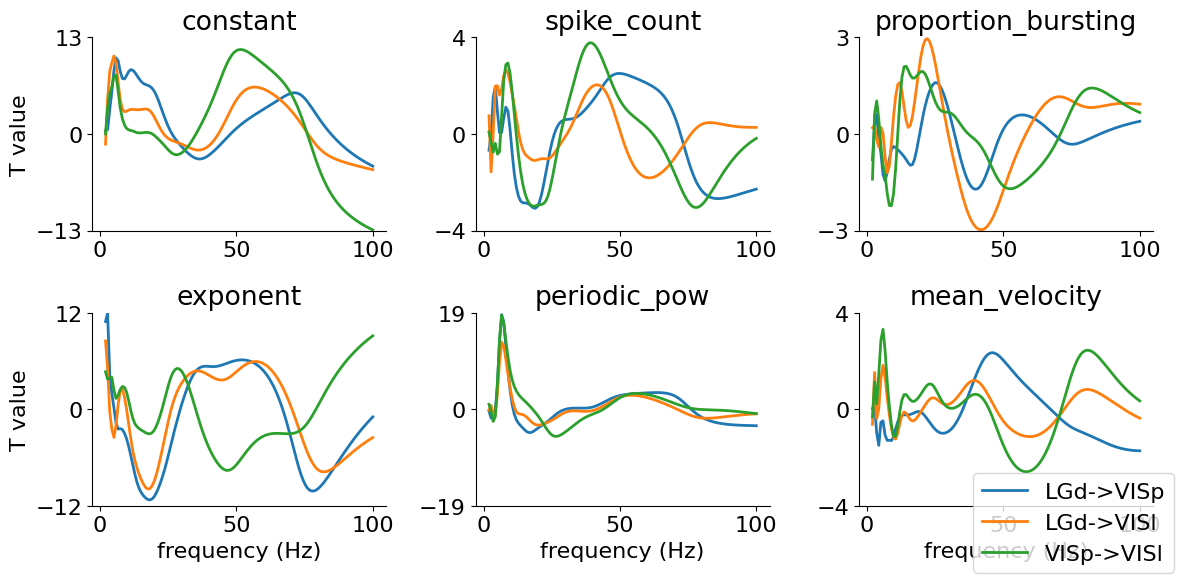

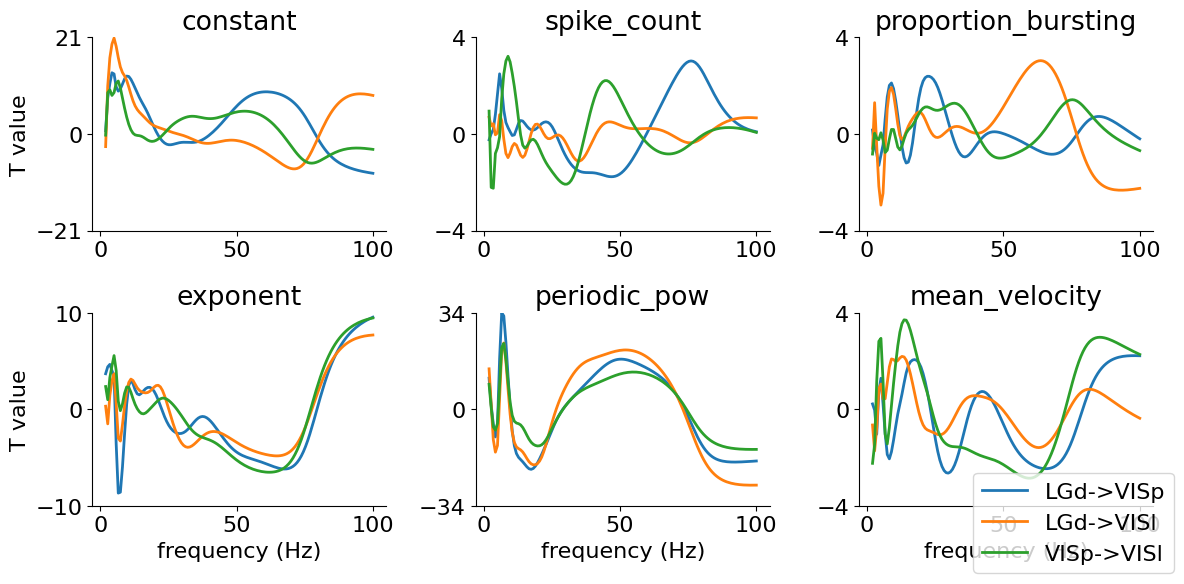

In [3]:
res_dir = 'results/tfr/'


# load features
df = pd.read_csv('results/feature_df.csv')
X_FEATURE = ['spike_count','proportion_bursting','exponent','periodic_pow','mean_velocity']
regressors = ['constant','spike_count','proportion_bursting','exponent','periodic_pow','mean_velocity']

for session_id in SESSIONS:

    fig, ax = plt.subplots(2,3,figsize = (12,6))
    ax = ax.ravel()

    max_val = np.zeros((3,6))

    STRUCTURES = [['LGd','VISl'], ['LGd','VISp'], ['VISl','VISp']]

    for h,s in enumerate(STRUCTURES):
        xs,ys = s
        tfr = np.load(res_dir + str(session_id) + '_' + ys + '.npy')


        # GLM spectrum
        df_s = df[df['session_id'] == session_id]
        x = df_s[df_s['brain_structure'] == xs][X_FEATURE].values
        x = np.concatenate((np.ones((len(x),1)),x),axis=1)
        contrasts = np.eye(x.shape[1])
        betas_tfr,copes,varcopes_tfr = ols_fit(x,tfr,contrasts)
        T_tfr = betas_tfr/np.sqrt(varcopes_tfr)

        freq = np.linspace(*FREQS)

        plt.rcParams.update({'font.size': 16})

        for i,T in enumerate(T_tfr):
            ax[i].plot(freq, T,linewidth=2.)
            ax[i].set_title(regressors[i])
            if i > 2:
                ax[i].set_xlabel('frequency (Hz)')

            max_val[h,i] = np.ceil(np.max(np.abs(T)))
            ax[i].spines[['right', 'top']].set_visible(False)

        ax[0].set_ylabel('T value')
        ax[3].set_ylabel('T value')

    max_val = np.max(max_val,axis=0)
    for i,m in enumerate(max_val):
        ax[i].set_ylim((-m,m))
        ax[i].set_yticks(np.linspace(-m,m,3))

    fig.legend(('LGd->VISp','LGd->VISl', 'VISp->VISl'),loc='lower right')
    fig.tight_layout()
    fig.savefig(res_dir + 'session_' + str(session_id) + '.png', dpi=300)

In [4]:
s = ['LGd','VISp','VISl']
tfr = [None] * 3
x = [None] * 3
lg,v1,v2 = s
# null distribution

session_id = SESSIONS[2]
tfr[0] = np.load(res_dir + str(session_id) + '_' + lg + '.npy')
tfr[1] = np.load(res_dir + str(session_id) + '_' + v1 + '.npy')
tfr[2] = np.load(res_dir + str(session_id) + '_' + v2 + '.npy')

session_id1 = SESSIONS[0]
session_id2 = SESSIONS[1]
session_id3 = SESSIONS[2]
# GLM spectrum
df_s = df[df['session_id'] == session_id2]
x[1] = df_s[df_s['brain_structure'] == v1][X_FEATURE].values
df_s = df[df['session_id'] == session_id1]
x[0] = df_s[df_s['brain_structure'] == lg][X_FEATURE].values
df_s = df[df['session_id'] == session_id3]
x[2] = df_s[df_s['brain_structure'] == v2][X_FEATURE].values

In [5]:
from itertools import combinations

In [6]:
design_comp = list(combinations([0,1,2],2))

In [ ]:
corr_x1x2 = []
for d1,d2 in design_comp:
    for xc1, xc2 in zip(x[d1].T,x[d2].T): 
        corr_x1x2.append(np.corrcoef(xc1,xc2)[0,1])
    
corr_x1x2 = np.array(corr_x1x2)


In [ ]:
corr_x1x2

In [8]:
# null distribution for SESSIONS[2]
session_id = SESSIONS[0]
s = ['LGd','VISp','VISl']
tfr = [None] * 3
x = [None] * 3
lg,v1,v2 = s

tfr[0] = np.load(res_dir + str(session_id) + '_' + lg + '.npy')
tfr[1] = np.load(res_dir + str(session_id) + '_' + v1 + '.npy')
tfr[2] = np.load(res_dir + str(session_id) + '_' + v2 + '.npy')

# GLM spectrum
df_s = df[df['session_id'] == session_id2]
x[1] = df_s[df_s['brain_structure'] == v1][X_FEATURE].values
df_s = df[df['session_id'] == session_id1]
x[0] = df_s[df_s['brain_structure'] == lg][X_FEATURE].values
df_s = df[df['session_id'] == session_id3]
x[2] = df_s[df_s['brain_structure'] == v2][X_FEATURE].values

contrasts = np.eye(6)
T_null = np.zeros((2,3,5000,6,len(freq)))
id_region = np.arange(len(s))
for d1 in id_region:
    comb_region = id_region[id_region != d1]
    for di, d2 in enumerate(comb_region):
        for i in range(5000):
            k_fold = np.random.choice(len(x[0]),size=len(x[0])-1)

            # null distribution session 2
            y = tfr[d1][k_fold]
            x_design = np.concatenate((np.ones((len(x[d2][k_fold]),1)),x[d2][k_fold]),axis=1)

            betas,copes,varcopes = ols_fit(x_design,y,contrasts)
            T = betas/np.sqrt(varcopes)

            T_null[di,d1,i] = T
T_null = np.concatenate((T_null[0],T_null[1]),axis=1) 

In [16]:
T_null = np.concatenate((T_null[0],T_null[1],T_null[2]),axis=1) 

In [12]:
from statsmodels.stats.multitest import multipletests
col = ['tab:blue','tab:orange','tab:green']

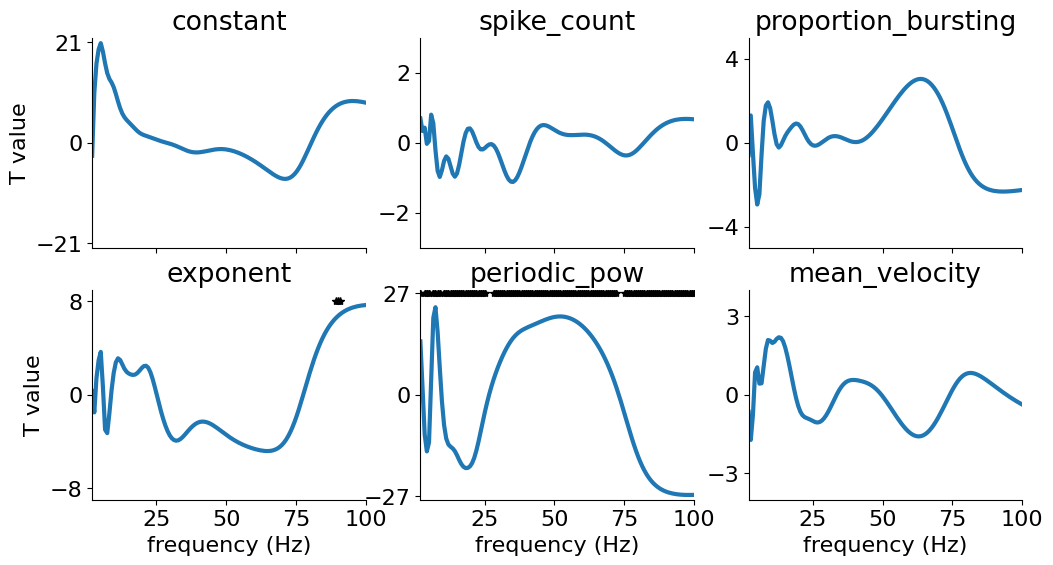

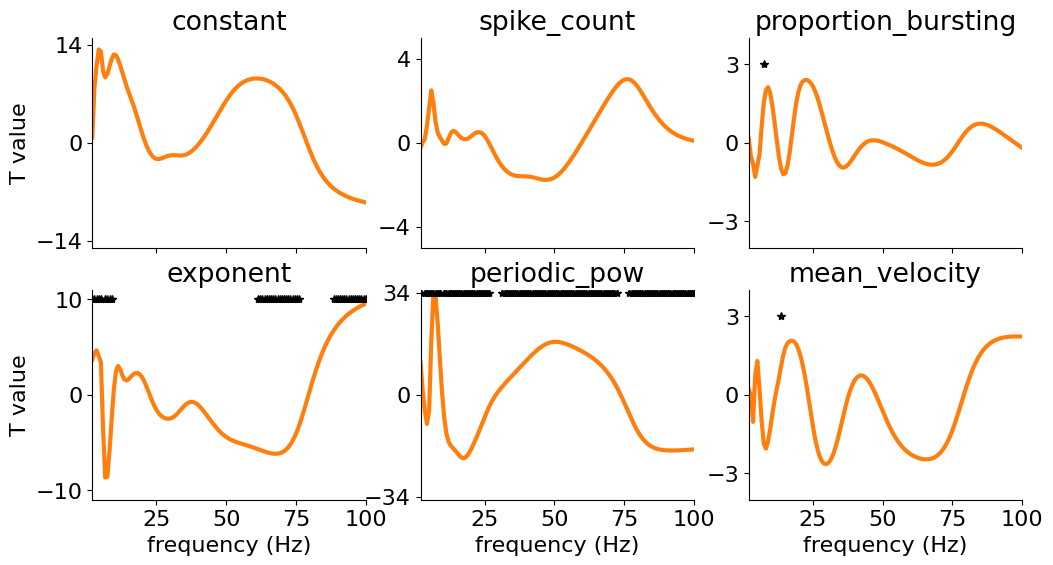

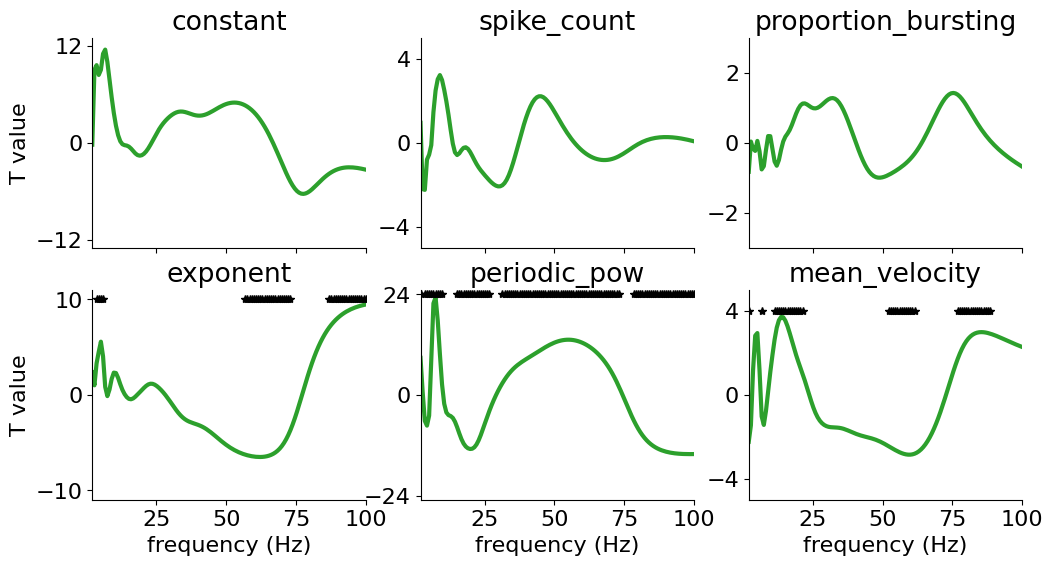

In [19]:
session_id = SESSIONS[2]
STRUCTURES = [['LGd','VISp'], ['LGd','VISl'], ['VISl','VISp'],]
regressors = ['constant','spike_count','proportion_bursting','exponent','periodic_pow','mean_velocity']

pvals = np.zeros((3,4,T_tfr.shape[1]))

for h,s in enumerate(STRUCTURES):
    xs,ys = s
    tfr = np.load(res_dir + str(session_id) + '_' + ys + '.npy')

    
    # GLM spectrum
    df_s = df[df['session_id'] == session_id]
    x = df_s[df_s['brain_structure'] == xs][X_FEATURE].values
    x = np.concatenate((np.ones((len(x),1)),x),axis=1)
    contrasts = np.eye(x.shape[1])
    betas_tfr,copes,varcopes_tfr = ols_fit(x,tfr,contrasts)
    T_tfr = betas_tfr/np.sqrt(varcopes_tfr)
    
    fig, ax = plt.subplots(2,3,figsize = (12,6),sharex=True)
    ax = ax.ravel()
    
    for i,T in enumerate(T_tfr):
        
        ax[i].plot(freq, T,linewidth=3.,color=col[h])
        
        m = np.ceil(np.max(np.abs(T)))
        ax[i].set_ylim((-m-1,m+1))
        ax[i].set_yticks(np.linspace(-m,m,3))
        
        if i > 1:
            pvals = np.zeros((T_tfr.shape[1],))
            for f in np.arange(T_tfr.shape[1]):
                counts,bins = np.histogram(T_null[:,i,f].squeeze(),density=True,bins=100)
                bins = bins[1:]
                pvals[f] = counts[np.argmin(np.abs(bins-T[f]))]
        
            sign_tp = multipletests(pvals,0.05,method='fdr_by')[0]
            if len(freq[sign_tp]):
                ax[i].plot(freq[sign_tp],np.ones((np.sum(sign_tp),))*(m),'*',color='k',linewidth=3, markersize=6)
        
        if i > 2:
            ax[i].set_xlabel('frequency (Hz)')
        ax[i].set_xlim([2, 100])
        ax[i].set_title(regressors[i])
        ax[i].spines[['right', 'top']].set_visible(False)
        ax[0].set_ylabel('T value')
        ax[3].set_ylabel('T value')
        
        fig.savefig(res_dir + 'session_' + str(session_id) + '_struct_' + '-'.join(s) + '_with_pval.svg', dpi=300)
        fig.savefig(res_dir + 'session_' + str(session_id) + '_struct_' + '-'.join(s) + '_with_pval.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (12,3),width_ratios=[3,2])
pc = ax[0].pcolormesh(np.arange(1800),freq,tfr.T,cmap='YlOrBr',vmin=0,vmax=1)
ax[0].set_ylabel('frequency Hz')
ax[0].set_xlabel('trial')
cb = fig.colorbar(pc)
cb.set_ticks([0,0.5,1])
ax[1].plot(freq,tfr[0])
ax[1].set_ylabel('power $mV^2$')
ax[1].set_xlabel('frequency (Hz)')
ax[1].spines[['right', 'top']].set_visible(False)
fig.tight_layout()
fig.savefig(res_dir + 'spectra.svg',dpi=300)
fig.savefig(res_dir + 'spectra.png',dpi=300)

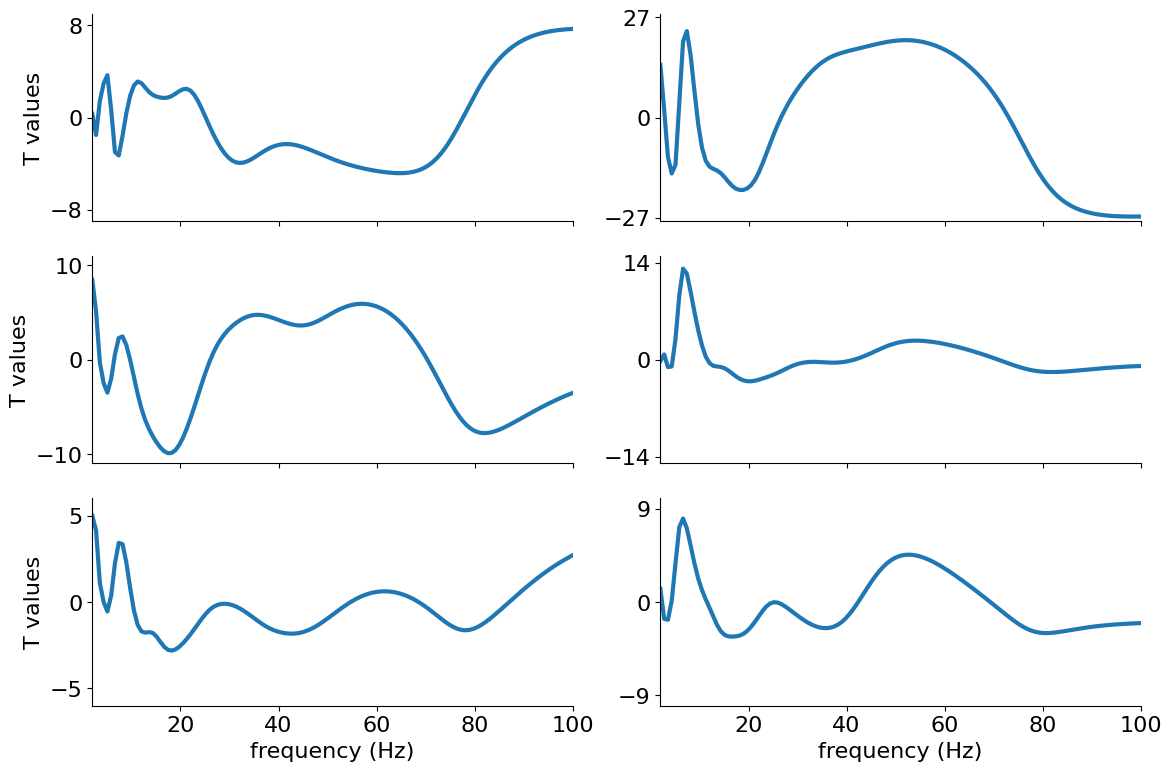

In [37]:
SESSIONS = [835479236, 768515987,766640955]
s = ['LGd','VISp']#, ['LGd','VISl'], ['VISl','VISp']]
X_FEATURE = ['spike_count','proportion_bursting','exponent','periodic_pow','mean_velocity']
regressors = ['exponent','periodic_pow']

pvals = np.zeros((len(SESSIONS),3,T.shape[0],))

fig, ax = plt.subplots(3,2,figsize = (12,8),sharex=True)

for si,session_id in enumerate(SESSIONS):

    xs,ys = s
    tfr = np.load(res_dir + str(session_id) + '_' + ys + '.npy')
    
    # GLM spectrum
    df_s = df[df['session_id'] == session_id]
    x = df_s[df_s['brain_structure'] == xs][X_FEATURE].values
    x = np.concatenate((np.ones((len(x),1)),x),axis=1)
    contrasts = np.eye(x.shape[1])
    betas_tfr,copes,varcopes_tfr = ols_fit(x,tfr,contrasts)
    T_tfr = betas_tfr/np.sqrt(varcopes_tfr)
    
    for i,T in enumerate(T_tfr[3:5]):
        
        ax[si,i].plot(freq, T,linewidth=3.,color=col[0])
 
        m = np.ceil(np.max(np.abs(T)))
        ax[si,i].set_ylim((-m-1,m+1))
        ax[si,i].set_yticks(np.linspace(-m,m,3))
        
        if i > 2:
            ax[i].set_xlabel('frequency (Hz)')
        ax[si,i].set_xlim([2, 100])
        #ax[si,i].set_ylabel(regressors[i])
        ax[si,i].spines[['right', 'top']].set_visible(False)
        
#        for f in np.arange(T.shape[0]):
#            counts,bins = np.histogram(T_null[:,i,f].squeeze(),density=True,bins=100)
#            bins = bins[1:]
#            pvals[si,i,f] = counts[np.argmin(np.abs(bins-T[f]))]
            
            
#sign_tp = multipletests(pvals.reshape(-1,),0.05,method='fdr_by')[0]
#sign_tp = sign_tp.reshape(len(SESSIONS),3,-1)
#for si,session_id in enumerate(SESSIONS):
#    for i,T in enumerate(T_tfr[3:5]):
#        m = np.ceil(np.max(np.abs(T)))
#        ax[si,i].plot(freq[sign_tp[si,i]],np.ones((np.sum(sign_tp[si,i]),))*(m),'*',color='k',linewidth=3, markersize=6)

          
ax[0,0].set_ylabel('T values')
ax[1,0].set_ylabel('T values')
ax[2,0].set_ylabel('T values')

ax[2,0].set_xlabel('frequency (Hz)')
ax[2,1].set_xlabel('frequency (Hz)')
fig.tight_layout()
fig.savefig(res_dir + 'comp_session_struct_' + '-'.join(s) + '_with_pval.svg', dpi=300)
fig.savefig(res_dir + 'comp_session_struct_' + '-'.join(s) + '_with_pval.png', dpi=300)

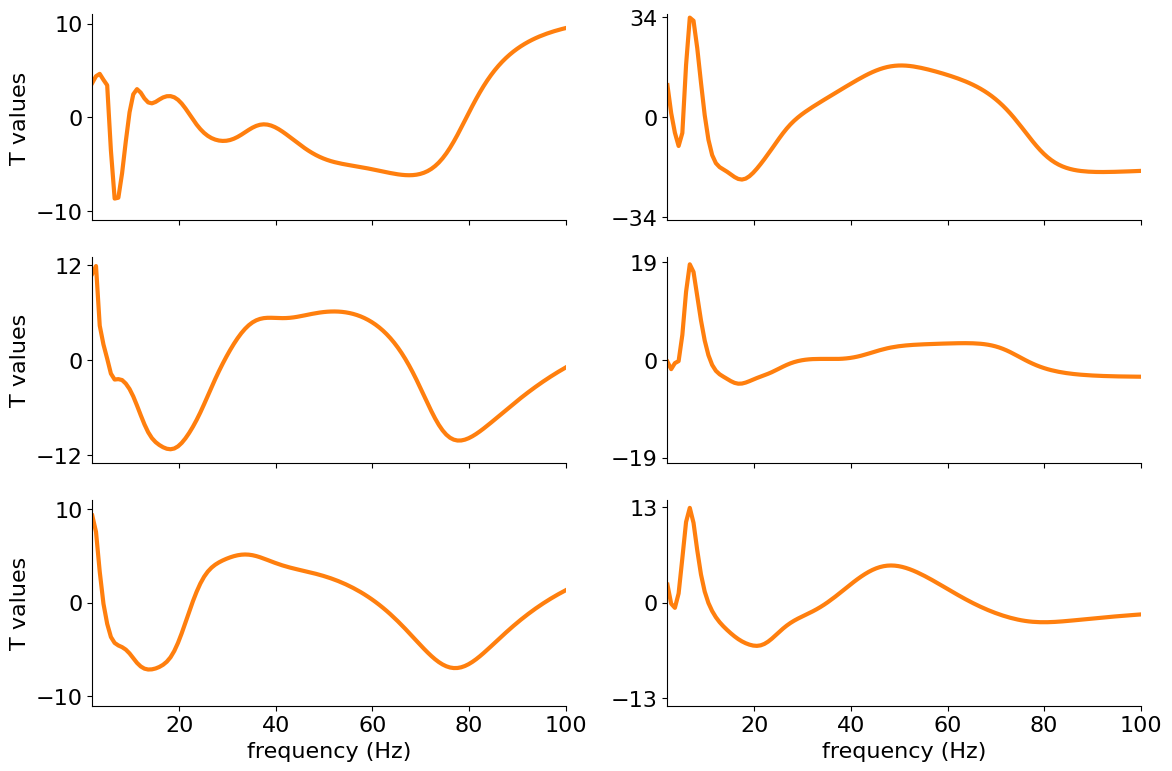

In [33]:
SESSIONS = [835479236, 768515987,766640955]
s = ['LGd','VISl']#, ['LGd','VISl'], ['VISl','VISp']]
X_FEATURE = ['spike_count','proportion_bursting','exponent','periodic_pow','mean_velocity']
regressors = ['exponent','periodic_pow']
fig, ax = plt.subplots(3,2,figsize = (12,8),sharex=True)
pval = np.zeros((len(regressors),3))
for si,session_id in enumerate(SESSIONS):

    xs,ys = s
    tfr = np.load(res_dir + str(session_id) + '_' + ys + '.npy')
    
    # GLM spectrum
    df_s = df[df['session_id'] == session_id]
    x = df_s[df_s['brain_structure'] == xs][X_FEATURE].values
    x = np.concatenate((np.ones((len(x),1)),x),axis=1)
    contrasts = np.eye(x.shape[1])
    betas_tfr,copes,varcopes_tfr = ols_fit(x,tfr,contrasts)
    T_tfr = betas_tfr/np.sqrt(varcopes_tfr)
    for i,T in enumerate(T_tfr[3:5]):
        
        ax[si,i].plot(freq, T,linewidth=3.,color=col[1])
 
        m = np.ceil(np.max(np.abs(T)))
        ax[si,i].set_ylim((-m-1,m+1))
        ax[si,i].set_yticks(np.linspace(-m,m,3))
        
        if i > 2:
            ax[i].set_xlabel('frequency (Hz)')
        ax[si,i].set_xlim([2, 100])
        #ax[si,i].set_ylabel(regressors[i])
        ax[si,i].spines[['right', 'top']].set_visible(False)
          
ax[0,0].set_ylabel('T values')
ax[1,0].set_ylabel('T values')
ax[2,0].set_ylabel('T values')

ax[2,0].set_xlabel('frequency (Hz)')
ax[2,1].set_xlabel('frequency (Hz)')
fig.tight_layout()
fig.savefig(res_dir + 'comp_session_struct_' + '-'.join(s) + '_with_pval.svg', dpi=300)
fig.savefig(res_dir + 'comp_session_struct_' + '-'.join(s) + '_with_pval.png', dpi=300)

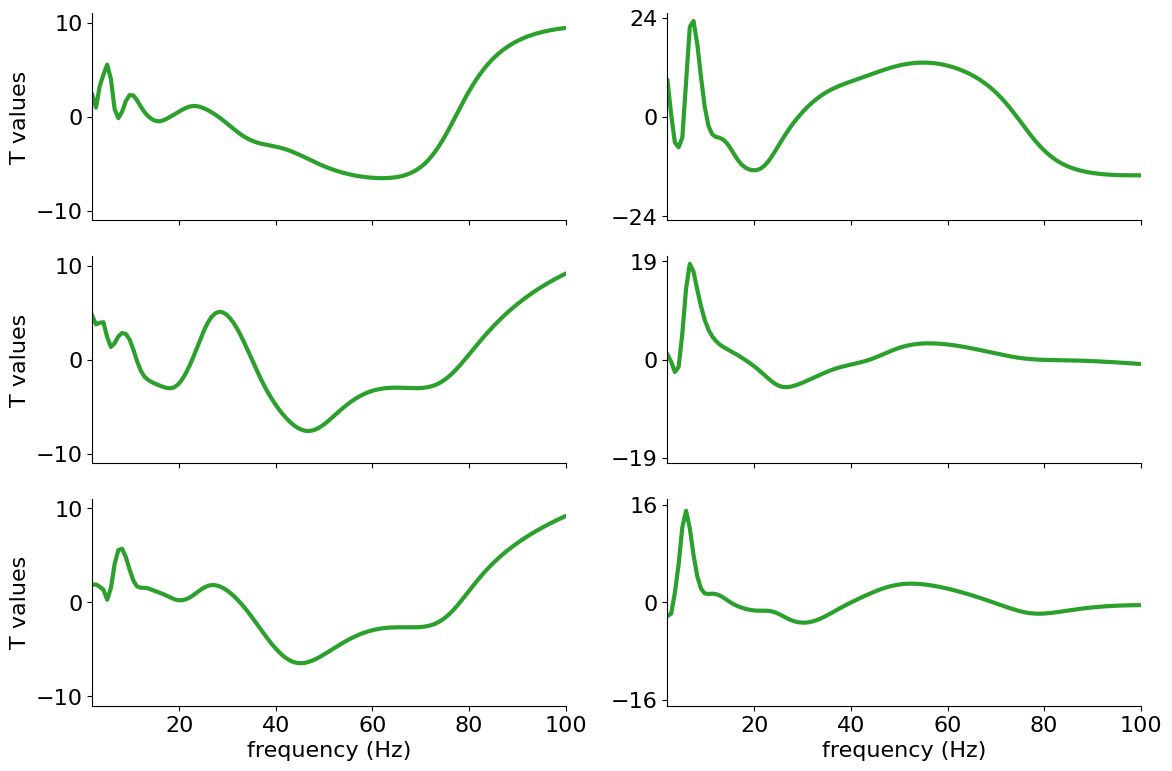

In [34]:
SESSIONS = [835479236, 768515987,766640955]
s = ['VISl','VISp']#, ['LGd','VISl'], ['VISl','VISp']]
X_FEATURE = ['spike_count','proportion_bursting','exponent','periodic_pow','mean_velocity']
regressors = ['exponent','periodic_pow']
fig, ax = plt.subplots(3,2,figsize = (12,8),sharex=True)

for si,session_id in enumerate(SESSIONS):

    xs,ys = s
    tfr = np.load(res_dir + str(session_id) + '_' + ys + '.npy')
    
    # GLM spectrum
    df_s = df[df['session_id'] == session_id]
    x = df_s[df_s['brain_structure'] == xs][X_FEATURE].values
    x = np.concatenate((np.ones((len(x),1)),x),axis=1)
    contrasts = np.eye(x.shape[1])
    betas_tfr,copes,varcopes_tfr = ols_fit(x,tfr,contrasts)
    T_tfr = betas_tfr/np.sqrt(varcopes_tfr)
    for i,T in enumerate(T_tfr[3:5]):
        
        ax[si,i].plot(freq, T,linewidth=3.,color=col[2])
 
        m = np.ceil(np.max(np.abs(T)))
        ax[si,i].set_ylim((-m-1,m+1))
        ax[si,i].set_yticks(np.linspace(-m,m,3))
        
        if i > 2:
            ax[i].set_xlabel('frequency (Hz)')
        ax[si,i].set_xlim([2, 100])
        #ax[si,i].set_ylabel(regressors[i])
        ax[si,i].spines[['right', 'top']].set_visible(False)
          
ax[0,0].set_ylabel('T values')
ax[1,0].set_ylabel('T values')
ax[2,0].set_ylabel('T values')

ax[2,0].set_xlabel('frequency (Hz)')
ax[2,1].set_xlabel('frequency (Hz)')
fig.tight_layout()
fig.savefig(res_dir + 'comp_session_struct_' + '-'.join(s) + '_with_pval.svg', dpi=300)
fig.savefig(res_dir + 'comp_session_struct_' + '-'.join(s) + '_with_pval.png', dpi=300)

In [ ]:
counts,bins = np.histogram(T_null[2,:,i,f].squeeze(),density=True,bins=100)
bins = bins[1:]
pvals[f] = counts[np.argmin(np.abs(bins-T[f]))]